In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator
from medmnist import BreastMNIST

ModuleNotFoundError: No module named 'numpy'

# Data Preparation

In [98]:
# medmnist version
print(medmnist.__version__)

3.0.2


In [99]:
# load train/ test datasets
train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [100]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [101]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [102]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [103]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [104]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [106]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

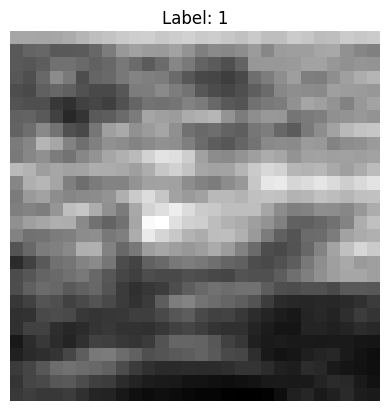

In [107]:
# visualize a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [108]:
print("shape:",img_np.shape)

shape: (28, 28)


In [109]:
# save images and labels in a list
images = []
labels = []

for img, label in test_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [110]:
# create a df of the extracted data
test_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [111]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [112]:
X_train = np.stack(train_df['image'].values)
y_train = np.array(train_df['label'].values)

X_test = np.stack(test_df['image'].values)
y_test = np.array(test_df['label'].values)

In [113]:
X_train.shape

(546, 28, 28)

In [114]:
X_train.shape

(546, 28, 28)

In [115]:
# PCA expects array of dim 2 as input --> flatten the 28x28 matrix to 784 features
X_train_flat = X_train.reshape(X_train.shape[0], -1) # X_train.shape[0] keeps number of samples, -1 flattens everything else in one long vector
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
X_train_flat.shape

(546, 784)

In [116]:
# Apply PCA
n_features = 8
pca = PCA(n_components=n_features)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca  = pca.transform(X_test_flat)

In [117]:
print(X_train_pca.shape)  # (546, 8)
print(X_test_pca.shape)   # (whatever test samples, 8)

(546, 8)
(156, 8)


In [118]:
# convert X,y into torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y__train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

In [119]:
# Convert to tensors
X_train_t = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

# QCNN Approach 1

In [120]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

In [121]:
n_qubits = n_features

def angle_encoding(qc, x):
    """Encode classical data using RY rotations"""
    for i in range(n_qubits): # loop through each qubit
        qc.ry(x[i],i) # apply RY (rotation around y-axis) gate to qubit i, rotation angle is x[i]

In [122]:
# create a quantum circuit instance
qc = QuantumCircuit(n_qubits)

# define the input parameters
input_params = []
for i in range(n_qubits):
    parameter = Parameter(f"x{i}")  # create placeholder parameters
    input_params.append(parameter)

theta_params = []
for i in range(n_qubits):
    param = Parameter(f'θ{i}') # create placeholders for weights that can be adjusted
    theta_params.append(param)

print(qc)


     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
q_5: 
     
q_6: 
     
q_7: 
     


In [123]:
# Angle encoding layer: RY rotations with input data
for i in range(n_qubits):
    qc.ry(input_params[i], i) # encode data in quantum states
print(qc)

     ┌────────┐
q_0: ┤ Ry(x0) ├
     ├────────┤
q_1: ┤ Ry(x1) ├
     ├────────┤
q_2: ┤ Ry(x2) ├
     ├────────┤
q_3: ┤ Ry(x3) ├
     ├────────┤
q_4: ┤ Ry(x4) ├
     ├────────┤
q_5: ┤ Ry(x5) ├
     ├────────┤
q_6: ┤ Ry(x6) ├
     ├────────┤
q_7: ┤ Ry(x7) ├
     └────────┘


In [124]:
# Variational layer: trainable RX rotations
for i in range(n_qubits):
    qc.rx(theta_params[i], i) # create placeholders for weights that can be adjusted

print(qc)

     ┌────────┐┌────────┐
q_0: ┤ Ry(x0) ├┤ Rx(θ0) ├
     ├────────┤├────────┤
q_1: ┤ Ry(x1) ├┤ Rx(θ1) ├
     ├────────┤├────────┤
q_2: ┤ Ry(x2) ├┤ Rx(θ2) ├
     ├────────┤├────────┤
q_3: ┤ Ry(x3) ├┤ Rx(θ3) ├
     ├────────┤├────────┤
q_4: ┤ Ry(x4) ├┤ Rx(θ4) ├
     ├────────┤├────────┤
q_5: ┤ Ry(x5) ├┤ Rx(θ5) ├
     ├────────┤├────────┤
q_6: ┤ Ry(x6) ├┤ Rx(θ6) ├
     ├────────┤├────────┤
q_7: ┤ Ry(x7) ├┤ Rx(θ7) ├
     └────────┘└────────┘


This represents the trainable part.
Rotating each qubit by a learned amount (theta angles). RX= rotation around the x-axis. After the inital data rotation, apply a second rotation. The model learns the second rotation! 

In [125]:
# Entanglement layer: CNOT gates
for i in range(n_qubits - 1):
    qc.cx(i, i+1)

print(qc)

     ┌────────┐┌────────┐                                   
q_0: ┤ Ry(x0) ├┤ Rx(θ0) ├──■────────────────────────────────
     ├────────┤├────────┤┌─┴─┐                              
q_1: ┤ Ry(x1) ├┤ Rx(θ1) ├┤ X ├──■───────────────────────────
     ├────────┤├────────┤└───┘┌─┴─┐                         
q_2: ┤ Ry(x2) ├┤ Rx(θ2) ├─────┤ X ├──■──────────────────────
     ├────────┤├────────┤     └───┘┌─┴─┐                    
q_3: ┤ Ry(x3) ├┤ Rx(θ3) ├──────────┤ X ├──■─────────────────
     ├────────┤├────────┤          └───┘┌─┴─┐               
q_4: ┤ Ry(x4) ├┤ Rx(θ4) ├───────────────┤ X ├──■────────────
     ├────────┤├────────┤               └───┘┌─┴─┐          
q_5: ┤ Ry(x5) ├┤ Rx(θ5) ├────────────────────┤ X ├──■───────
     ├────────┤├────────┤                    └───┘┌─┴─┐     
q_6: ┤ Ry(x6) ├┤ Rx(θ6) ├─────────────────────────┤ X ├──■──
     ├────────┤├────────┤                         └───┘┌─┴─┐
q_7: ┤ Ry(x7) ├┤ Rx(θ7) ├──────────────────────────────┤ X ├
     └────────┘└────────

Introduce entanglement by appling cnot-gates. This creates quantum correlations.
Qubits become correlated in ways that can not be achieved by classical bits. This allows the circuit
to find complex patterns in the data. 

# Assess performance over qubits

In [126]:
def build_qc(n_qubits):
    qc = QuantumCircuit(n_qubits)

    # input parameters x0, x1, ...
    input_params = [Parameter(f"x{i}") for i in range(n_qubits)]

    # trainable parameters θ0, θ1, ...
    theta_params = [Parameter(f"θ{i}") for i in range(n_qubits)]

    # Angle encoding
    for i in range(n_qubits):
        qc.ry(input_params[i], i)

    # Variational layer
    for i in range(n_qubits):
        qc.rx(theta_params[i], i)

    # Entanglement layer
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)

    return qc, input_params, theta_params

In [127]:
class QiskitQuantumLayer(nn.Module):
    def __init__(self, n_qubits, qc, input_params, theta_params):
        super().__init__()
        self.n_qubits = n_qubits
        self.qc = qc
        self.input_params = input_params
        self.theta_params = theta_params

        self.params = nn.Parameter(torch.randn(n_qubits))
        self.estimator = Estimator()

        # Z on each qubit
        self.observables = [
            SparsePauliOp("".join("Z" if j == i else "I" for j in range(n_qubits)))
            for i in range(n_qubits)
        ]

    def forward(self, x):
        outs = []
        for sample in x:
            pdict = {}

            for i,p in enumerate(self.input_params):
                pdict[p] = float(sample[i])

            for i,p in enumerate(self.theta_params):
                pdict[p] = float(self.params[i])

            circuit = self.qc.assign_parameters(pdict)

            circuits = [circuit] * self.n_qubits
            job = self.estimator.run(circuits, self.observables)
            result = job.result().values
            outs.append(result)

        return torch.tensor(outs, dtype=torch.float32)

In [128]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits, qc, input_params, theta_params, n_classes):
        super().__init__()
        self.quantum = QiskitQuantumLayer(n_qubits, qc, input_params, theta_params)
        self.fc = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        return self.fc(self.quantum(x))

In [129]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()   # positive class prob
        preds = logits.argmax(dim=1).cpu().numpy()

    y_true = y_test.cpu().numpy()

    # Confusion matrix
    cm = confusion_matrix(y_true, preds)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    return preds, probs, cm, (fpr, tpr, roc_auc)

In [130]:
import seaborn as sns

def plot_confusion_matrix(cm, qubits, class_names=["malignant", "normal/benign"]):
    plt.figure(figsize=(5, 4))
    
    # Normalize for percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt=".2f", 
        cmap="Blues", 
        cbar=True, 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix – {qubits} qubits")
    plt.tight_layout()
    plt.show()

In [131]:
def plot_roc(fpr_tpr_auc, qubits):
    fpr, tpr, roc_auc = fpr_tpr_auc
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {qubits} qubits")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [132]:
print(X_train_flat.shape)
print(X_test_flat.shape)

(546, 784)
(156, 784)


In [133]:
print(X_train.shape)
print(X_test.shape)

(546, 28, 28)
(156, 28, 28)


In [134]:
def train_and_evaluate_qubits(n_qubits, 
                              X_train_flat, X_test_flat, 
                              y_train, y_test, 
                              num_epochs=10,
                              random_state=42):

    import torch
    import numpy as np
    import random

    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    
    
    print(f"\n===== Training {n_qubits} Qubits =====")

    # --- PCA ---
    pca = PCA(n_components=n_qubits, random_state= random_state)
    X_train_pca = torch.tensor(pca.fit_transform(X_train_flat), dtype=torch.float32)
    X_test_pca  = torch.tensor(pca.transform(X_test_flat), dtype=torch.float32)

    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    # --- Build Hybrid Model ---
    qc, input_params, theta_params = build_qc(n_qubits)
    n_classes = len(np.unique(y_train))
    model = HybridModel(n_qubits, qc, input_params, theta_params, n_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    batch_size = 16

    # --- Training ---
    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(len(X_train_pca))

        for i in range(0, len(perm), batch_size):
            idx = perm[i:i+batch_size]
            Xb = X_train_pca[idx]
            yb = y_train_t[idx]

            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Loss = {loss.item():.4f}")

    # --- Evaluation ---
    preds, probs, cm, roc_info = evaluate_model(model, X_test_pca, y_test_t)

    acc = (preds == y_test).mean()

    print(f"Accuracy ({n_qubits} qubits): {acc:.4f}")

    plot_confusion_matrix(cm, n_qubits)
    plot_roc(roc_info, n_qubits)

    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "roc_auc": roc_info[2]
    }



===== Training 1 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_33446/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/100 | Loss = 0.3946
Epoch 2/100 | Loss = 0.3268
Epoch 3/100 | Loss = 0.8110
Epoch 4/100 | Loss = 0.3298
Epoch 5/100 | Loss = 0.8321
Epoch 6/100 | Loss = 0.3039
Epoch 7/100 | Loss = 0.2824
Epoch 8/100 | Loss = 0.8728
Epoch 9/100 | Loss = 0.8131
Epoch 10/100 | Loss = 0.3237
Epoch 11/100 | Loss = 0.8367
Epoch 12/100 | Loss = 1.3454
Epoch 13/100 | Loss = 1.2718
Epoch 14/100 | Loss = 0.3634
Epoch 15/100 | Loss = 0.3056
Epoch 16/100 | Loss = 1.3039
Epoch 17/100 | Loss = 0.8137
Epoch 18/100 | Loss = 0.8444
Epoch 19/100 | Loss = 0.7754
Epoch 20/100 | Loss = 0.3234
Epoch 21/100 | Loss = 0.7642
Epoch 22/100 | Loss = 0.7904
Epoch 23/100 | Loss = 0.7234
Epoch 24/100 | Loss = 0.3098
Epoch 25/100 | Loss = 0.7706
Epoch 26/100 | Loss = 0.7465
Epoch 27/100 | Loss = 0.7309
Epoch 28/100 | Loss = 0.8807
Epoch 29/100 | Loss = 0.3446
Epoch 30/100 | Loss = 0.3134
Epoch 31/100 | Loss = 0.3067
Epoch 32/100 | Loss = 0.3102
Epoch 33/100 | Loss = 0.8295
Epoch 34/100 | Loss = 0.7921
Epoch 35/100 | Loss = 0

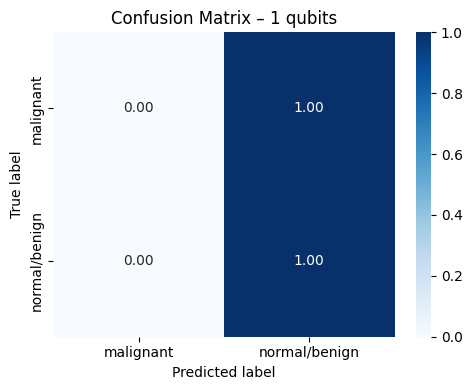

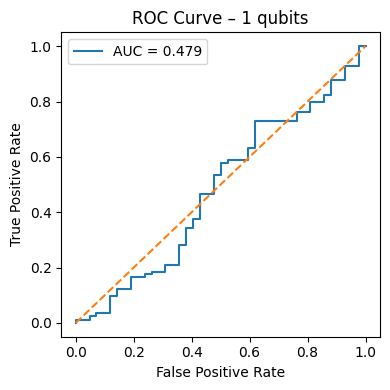


===== Training 2 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_33446/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/100 | Loss = 0.4789
Epoch 2/100 | Loss = 0.7809
Epoch 3/100 | Loss = 0.4630
Epoch 4/100 | Loss = 0.7085
Epoch 5/100 | Loss = 0.4183
Epoch 6/100 | Loss = 0.3582
Epoch 7/100 | Loss = 1.3027
Epoch 8/100 | Loss = 0.2966
Epoch 9/100 | Loss = 0.3565
Epoch 10/100 | Loss = 0.2861
Epoch 11/100 | Loss = 0.8365
Epoch 12/100 | Loss = 0.7259
Epoch 13/100 | Loss = 0.3261
Epoch 14/100 | Loss = 0.2989
Epoch 15/100 | Loss = 0.3252
Epoch 16/100 | Loss = 0.8401
Epoch 17/100 | Loss = 0.7559
Epoch 18/100 | Loss = 0.7752
Epoch 19/100 | Loss = 0.3246
Epoch 20/100 | Loss = 0.6566
Epoch 21/100 | Loss = 0.3135
Epoch 22/100 | Loss = 0.7945
Epoch 23/100 | Loss = 0.7761
Epoch 24/100 | Loss = 0.2999
Epoch 25/100 | Loss = 0.3010
Epoch 26/100 | Loss = 0.3120
Epoch 27/100 | Loss = 0.8867
Epoch 28/100 | Loss = 1.4221
Epoch 29/100 | Loss = 0.3422
Epoch 30/100 | Loss = 0.3696
Epoch 31/100 | Loss = 0.2885
Epoch 32/100 | Loss = 0.3028
Epoch 33/100 | Loss = 0.3047
Epoch 34/100 | Loss = 0.8415
Epoch 35/100 | Loss = 0

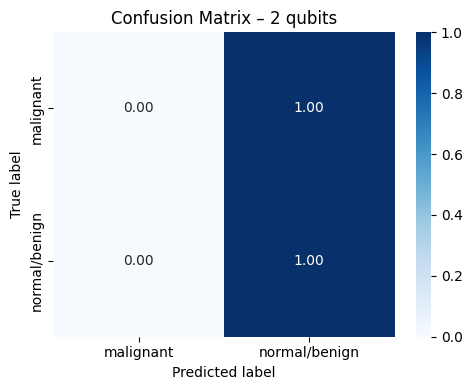

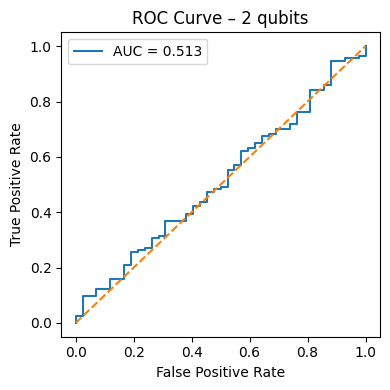


===== Training 5 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_33446/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/100 | Loss = 0.8084
Epoch 2/100 | Loss = 0.7454
Epoch 3/100 | Loss = 0.3387
Epoch 4/100 | Loss = 0.8556
Epoch 5/100 | Loss = 0.2557
Epoch 6/100 | Loss = 0.2980
Epoch 7/100 | Loss = 0.8870
Epoch 8/100 | Loss = 0.2962
Epoch 9/100 | Loss = 0.2240
Epoch 10/100 | Loss = 0.3078
Epoch 11/100 | Loss = 0.3314
Epoch 12/100 | Loss = 0.3622
Epoch 13/100 | Loss = 0.4708
Epoch 14/100 | Loss = 0.7390
Epoch 15/100 | Loss = 1.4456
Epoch 16/100 | Loss = 1.2837
Epoch 17/100 | Loss = 0.8313
Epoch 18/100 | Loss = 0.3064
Epoch 19/100 | Loss = 0.7478
Epoch 20/100 | Loss = 0.3090
Epoch 21/100 | Loss = 0.2695
Epoch 22/100 | Loss = 0.9720
Epoch 23/100 | Loss = 0.6273
Epoch 24/100 | Loss = 0.8027
Epoch 25/100 | Loss = 0.9997
Epoch 26/100 | Loss = 0.3993
Epoch 27/100 | Loss = 0.9197
Epoch 28/100 | Loss = 1.2231
Epoch 29/100 | Loss = 0.3181
Epoch 30/100 | Loss = 0.2021
Epoch 31/100 | Loss = 0.8842
Epoch 32/100 | Loss = 1.2780
Epoch 33/100 | Loss = 0.2998
Epoch 34/100 | Loss = 0.7982
Epoch 35/100 | Loss = 1

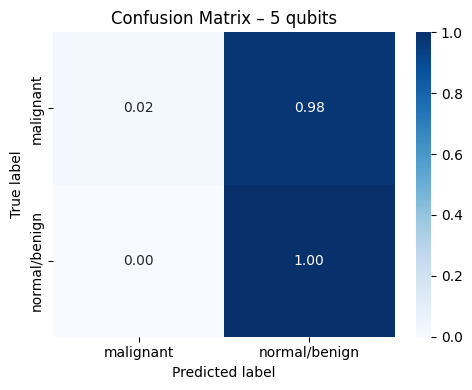

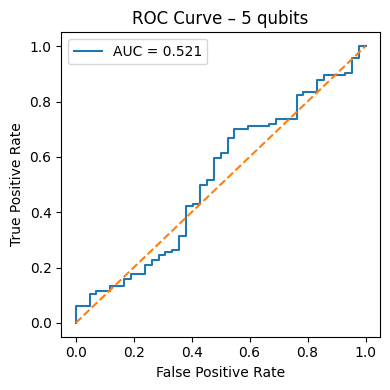


===== Training 10 Qubits =====


/var/folders/9j/mh4k6dbx5sldmm3_0tzdsch00000gn/T/ipykernel_33446/3724193794.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  self.estimator = Estimator()


Epoch 1/100 | Loss = 0.4750
Epoch 2/100 | Loss = 0.7676
Epoch 3/100 | Loss = 1.2383
Epoch 4/100 | Loss = 0.5650
Epoch 5/100 | Loss = 0.7151
Epoch 6/100 | Loss = 0.4017
Epoch 7/100 | Loss = 0.7767
Epoch 8/100 | Loss = 0.9029
Epoch 9/100 | Loss = 0.2302
Epoch 10/100 | Loss = 0.4236
Epoch 11/100 | Loss = 1.1847
Epoch 12/100 | Loss = 0.7647
Epoch 13/100 | Loss = 0.2698
Epoch 14/100 | Loss = 0.2774
Epoch 15/100 | Loss = 1.3350
Epoch 16/100 | Loss = 0.3421
Epoch 17/100 | Loss = 0.6928
Epoch 18/100 | Loss = 0.2742
Epoch 19/100 | Loss = 0.2957
Epoch 20/100 | Loss = 0.2680
Epoch 21/100 | Loss = 0.7272
Epoch 22/100 | Loss = 0.2236
Epoch 23/100 | Loss = 1.3962
Epoch 24/100 | Loss = 0.6298
Epoch 25/100 | Loss = 0.3415
Epoch 26/100 | Loss = 0.8557
Epoch 27/100 | Loss = 0.7501
Epoch 28/100 | Loss = 0.3482
Epoch 29/100 | Loss = 0.3067
Epoch 30/100 | Loss = 0.3831
Epoch 31/100 | Loss = 0.5435
Epoch 32/100 | Loss = 0.3364
Epoch 33/100 | Loss = 0.8131
Epoch 34/100 | Loss = 0.2414
Epoch 35/100 | Loss = 0

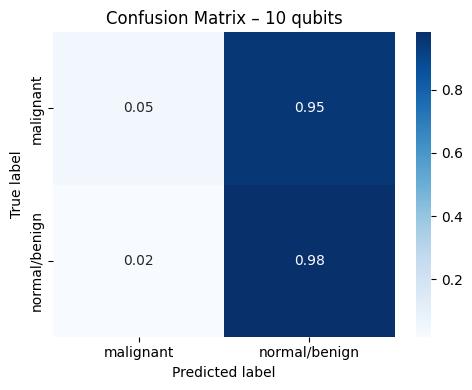

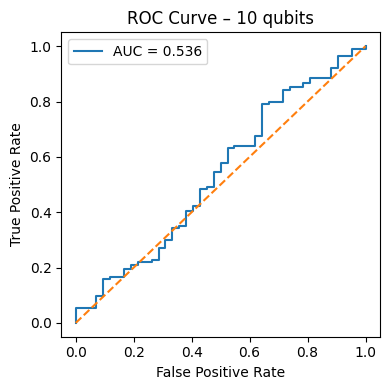


=== Summary ===
1 qubits → Acc=0.7308, AUC=0.4791
2 qubits → Acc=0.7308, AUC=0.5134
5 qubits → Acc=0.7372, AUC=0.5207
10 qubits → Acc=0.7308, AUC=0.5361


In [135]:
qubit_list = [1, 2, 5, 10]
results = {}

for q in qubit_list:
    results[q] = train_and_evaluate_qubits(
        q,
        X_train_flat, X_test_flat,
        y_train, y_test,
        num_epochs=100
    )

print("\n=== Summary ===")
for q, r in results.items():
    print(f"{q} qubits → Acc={r['accuracy']:.4f}, AUC={r['roc_auc']:.4f}")

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, qubits, class_names=["malignant", "benign/normal"]):
    plt.figure(figsize=(5, 4))
    
    # Heatmap with counts only
    sns.heatmap(
        cm, 
        annot=True,        # show numbers
        fmt="d",           # integer format
        cmap="Blues", 
        cbar=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        square=True
    )
    
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix – {qubits} qubits")
    plt.tight_layout()
    plt.show()


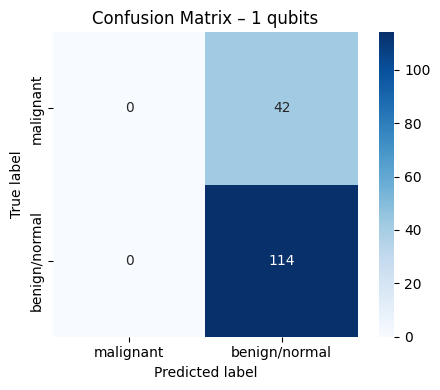

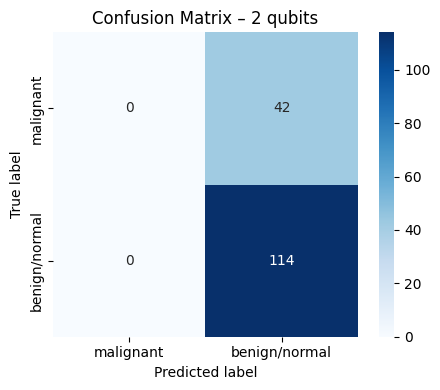

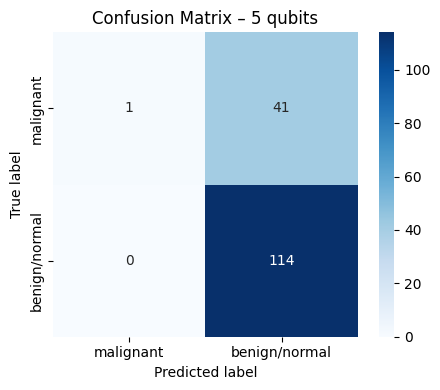

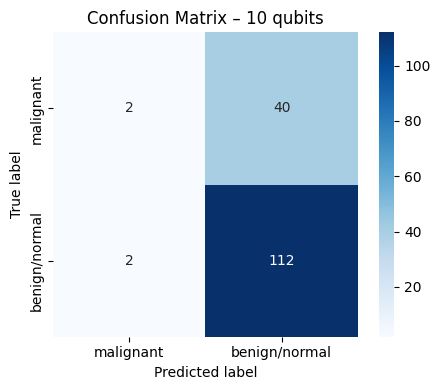

In [137]:
for q, r in results.items():
    plot_confusion_matrix(r["confusion_matrix"], qubits=q)

In [138]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_comparison(results, class_name="malignant vs benign/normal"):
    plt.figure(figsize=(6, 6))
    
    for q, r in results.items():
        probs = r.get("probs")  # should be 1D: probability for positive class
        y_true = r.get("y_true")
        
        if probs is None or y_true is None:
            print(f"Skipping {q} qubits: ROC data missing")
            continue
        
        probs = probs.flatten()  # ensure 1D
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f"{q} qubits (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Comparison – {class_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [139]:
def plot_accuracy_comparison(results):
    qubits = list(results.keys())
    accuracies = [results[q]['accuracy'] for q in qubits]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(qubits, accuracies, color='skyblue', edgecolor='black')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", 
                 ha='center', va='bottom', fontsize=10)
    
    plt.xticks(qubits)
    plt.ylim(0, 1)
    plt.xlabel("Number of Qubits")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy Comparison Across Qubit Counts")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


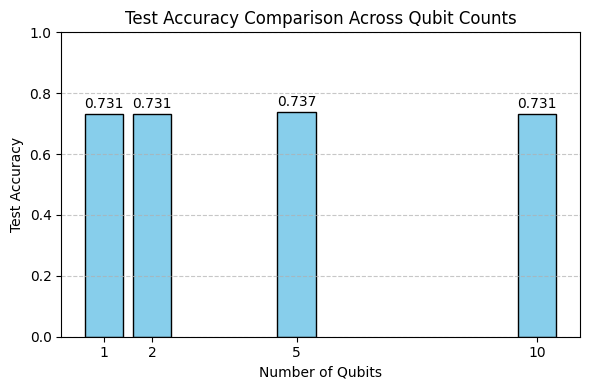

In [140]:
plot_accuracy_comparison(results)

In [141]:
# 114/156 = 0.73!
test_df["label"].value_counts()

label
1    114
0     42
Name: count, dtype: int64